# Zadání II. seminární práce z předmětu Počítačové zpracování signálu (KI/PZS)


## Klasifikace zvukových záznamů

Channels: ['voice']
Sampling frequency: 8000


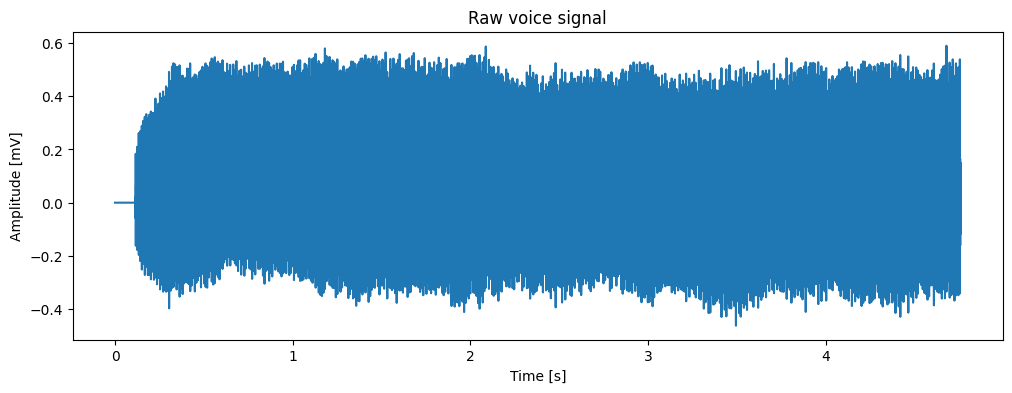

Sampling frequency: 8000 Hz
Signal length: 4.76 seconds


In [ ]:
# Importy
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.signal import find_peaks

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import scipy.fft as fft

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# NACTENI DAT
filepath = "C:\\Users\\Meter\\Desktop\\KI_PZS_Seminarky\\voiced-database-1.0.0\\voice-icar-federico-ii-database-1.0.0"
data = wfdb.rdrecord(filepath + "\\voice001")
voice_signal = data.p_signal[:, 0]
sampling_rate = data.fs
print("Channels:", getattr(data, "sig_name", None))
print("Sampling frequency:", data.fs)



plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(voice_signal))/sampling_rate, voice_signal)
plt.title("Raw voice signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.show()


print(f"Sampling frequency: {sampling_rate} Hz")
print(f"Signal length: {len(voice_signal)/sampling_rate:.2f} seconds")

# TAKHLE VYPADA SIGNAL


V tomto kódu načítám všechny hlasové záznamy z databáze, ke každému získám jeho signál a diagnózu z metadat a ukládám je do slovníku pro další zpracování a klasifikaci.

In [ ]:
voice_signal_diagnosis = {}
for i in range(1, 209, 1):
    record_path = os.path.join(filepath, f"voice{i:03d}")
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]
    
    diagnosis = "Unknown"
    for comment in record.comments:
        if "<diagnoses>:" in comment:
            diagnosis = comment.split("<diagnoses>:")[1].split("<")[0].strip()
            break
            
    voice_signal_diagnosis[f"voice{i:03d}"] = (signal, diagnosis)

print(f"Total records loaded: {len(voice_signal_diagnosis)}")
print("Unique diagnoses:", set(diagnosis for _, diagnosis in voice_signal_diagnosis.values()))



Total records loaded: 208
Unique diagnoses: {'hyperkinetic dysphonia', 'hypokinetic dysphonia', 'reflux laryngitis', 'hyperkineti dysphonia', 'healthy'}


Vizualizace signalu zdraveho cloveka a cloveka s patologií

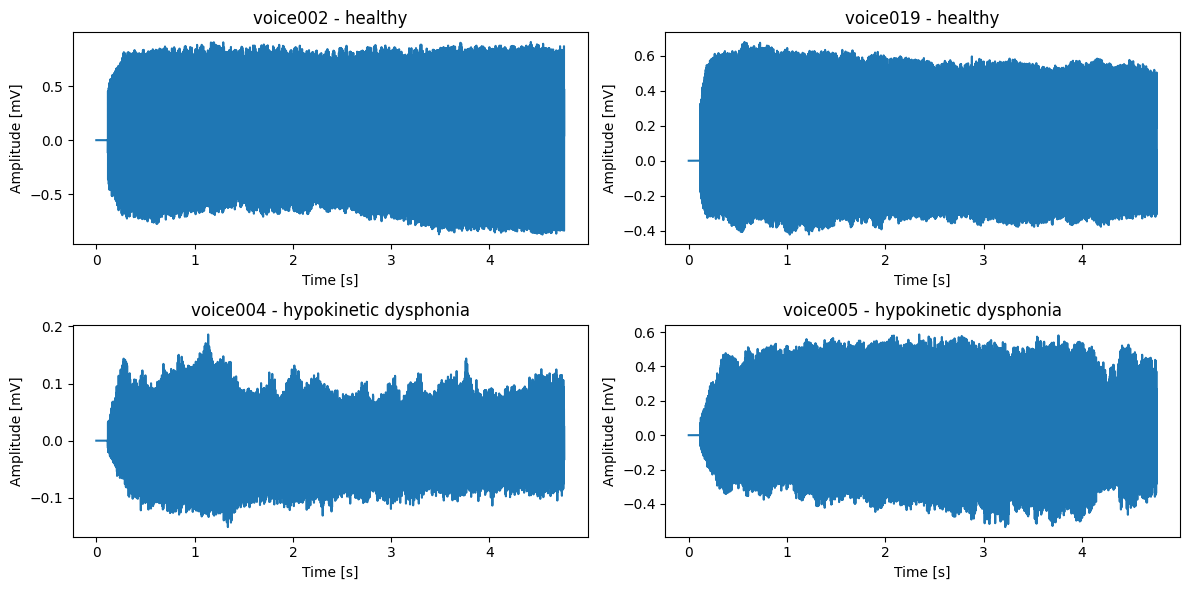

In [3]:
diagnosis_to_plot = ["healthy", "hypokinetic dysphonia"]

fig, axs = plt.subplots(len(diagnosis_to_plot), 2, figsize=(12, 6))
for i, diagnosis in enumerate(diagnosis_to_plot):
    count = 0
    for record_id, (signal, diag) in voice_signal_diagnosis.items():
        if diag == diagnosis:
            axs[i, count].plot(np.arange(len(signal))/sampling_rate, signal)
            axs[i, count].set_title(f"{record_id} - {diagnosis}")
            axs[i, count].set_xlabel("Time [s]")
            axs[i, count].set_ylabel("Amplitude [mV]")
            count += 1
            if count == 2:
                break
plt.tight_layout()
plt.show()

V této části vybírám pouze střední část hlasového záznamu a z ní počítám akustické parametry jitter a shimmer pro jednoduchou klasifikaci signálu na zdravý nebo patologický.

In [4]:
def calculate_acoustic_features(signal_data, fs = 8000):
    """
    Calculates Jitter and Shimmer for a given signal.
    Focuses on the middle 50% of the recording to avoid onset/offset artifacts.
    """
    
    n_samples = len(signal_data)
    start = int(n_samples * 0.25)
    end = int(n_samples * 0.75)
    trimmed_signal = signal_data[start:end]
    
  
    peaks, properties = find_peaks(trimmed_signal, 
                                          height=0.0, 
                                          distance=int(fs/500))
    
    if len(peaks) < 2:
        return np.nan, np.nan
        
  
    peak_times = peaks / fs
    periods = np.diff(peak_times) 
    
    if np.mean(periods) == 0:
        return np.nan, np.nan
        
    jitter_absolute = np.mean(np.abs(np.diff(periods)))
    jitter_percent = (jitter_absolute / np.mean(periods)) * 100
    
   
    amplitudes = properties['peak_heights']
    
    if np.mean(amplitudes) == 0:
        return np.nan, np.nan
        
    shimmer_absolute = np.mean(np.abs(np.diff(amplitudes)))
    shimmer_percent = (shimmer_absolute / np.mean(amplitudes)) * 100
    
    return jitter_percent, shimmer_percent


In [ ]:
def health_or_pathological(jit, shim):
    
    if np.isnan(jit) or np.isnan(shim):
        return "Unknown"
    if jit > 1.0 and shim > 3.0:
        return "Pathological"
    else:
        return "Healthy"
    

results = []

for record_id, (signal, diag) in voice_signal_diagnosis.items():
    jit, shim = calculate_acoustic_features(signal, fs=sampling_rate)
    health_status = health_or_pathological(jit, shim)
    
    results.append({
        "Record ID": record_id,
        "Diagnosis": diag,
        "Jitter (%)": jit,
        "Shimmer (%)": shim,
        "Predicted Diag": health_status
    })
results_df = pd.DataFrame(results)
print("Processing complete.")
print(results_df.head(20))

Processing complete.
   Record ID               Diagnosis  Jitter (%)  Shimmer (%) Predicted Diag
0   voice001  hyperkinetic dysphonia   29.318923   108.738312   Pathological
1   voice002                 healthy    3.973844    75.727319   Pathological
2   voice003  hyperkinetic dysphonia   16.312342   100.360052   Pathological
3   voice004   hypokinetic dysphonia   23.674155    77.210173   Pathological
4   voice005   hypokinetic dysphonia   47.892208    64.190446   Pathological
5   voice006  hyperkinetic dysphonia   35.905597    97.233775   Pathological
6   voice007  hyperkinetic dysphonia   34.711432    99.885002   Pathological
7   voice008       reflux laryngitis   26.416334    86.774208   Pathological
8   voice009  hyperkinetic dysphonia   46.513026   131.377742   Pathological
9   voice010   hypokinetic dysphonia   11.792967   156.303371   Pathological
10  voice011       reflux laryngitis   32.581753    66.061704   Pathological
11  voice012       reflux laryngitis   38.813414   167.

In [7]:

results_df['True_Status'] = results_df['Diagnosis'].apply(lambda x: "Healthy" if x == "healthy" else "Pathological")
accuracy = np.mean(results_df["Diagnosis"].str.lower().str.contains("healthy") == (results_df["Predicted Diag"] == "Healthy"))
print(f"Accuracy of health/pathological classification: {accuracy * 100:.2f}%")
conf_matrix = confusion_matrix(results_df['True_Status'], results_df['Predicted Diag'], labels=["Healthy", "Pathological"])
print("Confusion Matrix:")
print(pd.DataFrame(conf_matrix, 
                   index=["True Healthy", "True Pathological"],
                   columns=["Predicted Healthy", "Predicted Pathological"]))



Accuracy of health/pathological classification: 72.60%
Confusion Matrix:
                   Predicted Healthy  Predicted Pathological
True Healthy                       0                      57
True Pathological                  0                     151


In [8]:

accuracy = np.mean(results_df["Diagnosis"].str.lower().str.contains("healthy") == (results_df["Predicted Diag"] == "Healthy"))
print(f"Accuracy of health/pathological classification: {accuracy * 100:.2f}%")

Accuracy of health/pathological classification: 72.60%


In [11]:
def simplified_cepstrum(signal, fs):
    """
    Window -> FFT -> Log -> IFFT -> Height of biggest peak.
    """
    
    
    signal = signal - np.mean(signal)
    
    
    center = len(signal) // 2
    half_sec = int(fs / 2)
    start = max(0, center - half_sec)
    end = min(len(signal), center + half_sec)
    segment = signal[start:end]
    
    
    windowed = segment * np.hamming(len(segment))
    
    
    spectrum = np.abs(fft.rfft(windowed))
    log_spectrum = np.log(spectrum + 1e-9)
    cepstrum = np.abs(fft.irfft(log_spectrum))
    
    
    min_q = int(fs / 300) 
    max_q = int(fs / 60)
    
    if max_q >= len(cepstrum):
        max_q = len(cepstrum) - 1
        
    valid_region = cepstrum[min_q:max_q]
    
    if len(valid_region) == 0:
        return 0
        
    return np.max(valid_region)


print("Runing Simplified Cepstrum...")
results = []

for record_id, (sig, diag) in voice_signal_diagnosis.items():
    
    cpp_val = simplified_cepstrum(sig, fs=sampling_rate)
    
    raw_diag = str(diag).lower()
    status = 'Healthy' if 'healthy' in raw_diag else 'Pathological'
    
    results.append({'CPP': cpp_val, 'Status': status})

df_8k = pd.DataFrame(results)
print(df_8k.head())

Runing Simplified Cepstrum...
        CPP        Status
0  0.284798  Pathological
1  0.551311       Healthy
2  0.434002  Pathological
3  0.349029  Pathological
4  0.488814  Pathological


Simple Threshold (Median): 0.3288
Accuracy: 55.29%

Confusion Matrix:
                     Pred Healthy  Pred Patho
Actual Healthy                 34          23
Actual Pathological            70          81


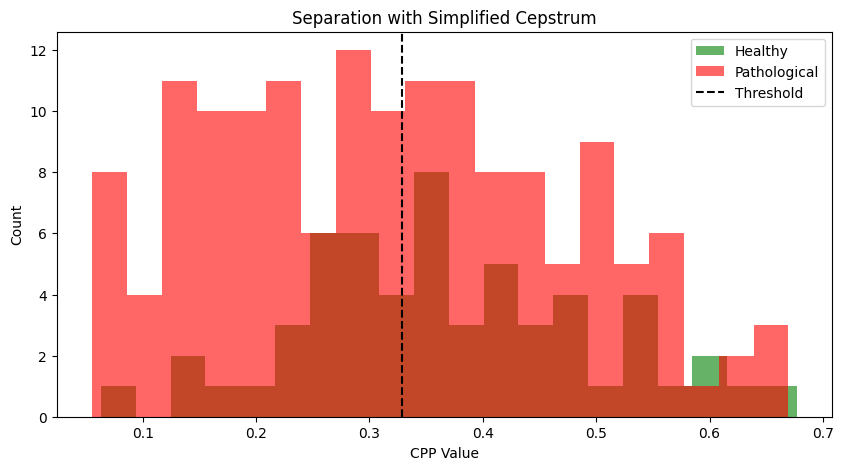

In [12]:
threshold = df_8k['CPP'].median()

print(f"Simple Threshold (Median): {threshold:.4f}")


df_8k['Prediction'] = df_8k['CPP'].apply(lambda x: 'Healthy' if x > threshold else 'Pathological')

acc = accuracy_score(df_8k['Status'], df_8k['Prediction'])
cm = confusion_matrix(df_8k['Status'], df_8k['Prediction'], labels=["Healthy", "Pathological"])

print(f"Accuracy: {acc * 100:.2f}%")
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=["Actual Healthy", "Actual Pathological"], columns=["Pred Healthy", "Pred Patho"]))

plt.figure(figsize=(10, 5))
plt.hist(df_8k[df_8k['Status']=='Healthy']['CPP'], bins=20, alpha=0.6, label='Healthy', color='green')
plt.hist(df_8k[df_8k['Status']=='Pathological']['CPP'], bins=20, alpha=0.6, label='Pathological', color='red')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title('Separation with Simplified Cepstrum')
plt.xlabel('CPP Value')
plt.ylabel('Count')
plt.legend()
plt.show()

In [13]:
def get_jitter_shimmer(signal_data, fs):
    try:
       
        signal_data = signal_data - np.mean(signal_data)
        
       
        peaks, props = find_peaks(signal_data, distance=int(fs/500), height=0)
        
        if len(peaks) < 10: return np.nan, np.nan 
        
        periods = np.diff(peaks / fs)
        amplitudes = props['peak_heights']
        
        if len(periods) < 2 or len(amplitudes) < 2: return np.nan, np.nan
        
  
        if np.mean(periods) == 0: jit = np.nan
        else: jit = np.mean(np.abs(np.diff(periods))) / np.mean(periods) * 100
        
        if np.mean(amplitudes) == 0: shim = np.nan
        else: shim = np.mean(np.abs(np.diff(amplitudes))) / np.mean(amplitudes) * 100
        
        return jit, shim
    except:
        return np.nan, np.nan

def get_cpp(signal_data, fs):
    try:
        if np.std(signal_data) == 0: return np.nan
        
        sig = (signal_data - np.mean(signal_data)) / np.std(signal_data)
        
        frame_len = int(0.04 * fs)
        hop = int(0.02 * fs)
        peaks = []
        
        for i in range(0, len(sig)-frame_len, hop):
            frame = sig[i:i+frame_len] * np.hanning(frame_len)
            spec = np.abs(fft.rfft(frame))
            ceps = np.abs(fft.irfft(np.log(spec + 1e-9)))
           
            if len(ceps) > 135:
                
                peaks.append(np.max(ceps[25:135]))
                
        return np.percentile(peaks, 90) if peaks else np.nan
    except:
        return np.nan



print("Processing Features...")
data_list = []
fs = sampling_rate

for record_id, (sig, diag) in voice_signal_diagnosis.items():
    jit, shim = get_jitter_shimmer(sig, fs)
    cpp = get_cpp(sig, fs)
    
    
    is_healthy = 'healthy' in str(diag).lower()
    label_code = 0 if is_healthy else 1
    label_str = 'Healthy' if is_healthy else 'Pathological'
    
    data_list.append([jit, shim, cpp, label_code, label_str])

df = pd.DataFrame(data_list, columns=['Jitter', 'Shimmer', 'CPP', 'Target', 'Status'])



imputer = SimpleImputer(strategy='median')
X = df[['Jitter', 'Shimmer', 'CPP']]
y = df['Target']

X_clean = imputer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


y_full_pred = rf.predict(X_clean)
acc_full = accuracy_score(y, y_full_pred)
cm_full = confusion_matrix(y, y_full_pred)

print(f"\n--- Results on Examples (Whole Dataset) ---")
print(f"Total Accuracy: {acc_full * 100:.2f}%")

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm_full, index=["Actual Healthy", "Actual Patho"], columns=["Pred Healthy", "Pred Patho"])
print(cm_df)


importances = rf.feature_importances_
print("\nFeature Importance:")
for name, imp in zip(['Jitter', 'Shimmer', 'CPP'], importances):
    print(f"{name}: {imp:.4f}")


df['Encoded_Pred'] = y_full_pred
df['Prediction'] = df['Encoded_Pred'].apply(lambda x: 'Healthy' if x==0 else 'Pathological')
print("\nSample of results:")
print(df.head(10))

Processing Features...

--- Results on Examples (Whole Dataset) ---
Total Accuracy: 92.79%

Confusion Matrix:
                Pred Healthy  Pred Patho
Actual Healthy            44          13
Actual Patho               2         149

Feature Importance:
Jitter: 0.3333
Shimmer: 0.3217
CPP: 0.3450

Sample of results:
      Jitter     Shimmer       CPP  Target        Status  Encoded_Pred  \
0  27.490068  110.939102  0.592688       1  Pathological             1   
1   4.249502   76.880543  0.703390       0       Healthy             0   
2  21.278831   99.474953  0.724102       1  Pathological             1   
3  24.357440   87.229662  0.545236       1  Pathological             1   
4  46.246395   61.994011  0.710965       1  Pathological             1   
5  36.169403   99.638661  0.631460       1  Pathological             1   
6  30.641321  103.341573  0.448056       1  Pathological             1   
7  25.267102   91.522984  0.726685       1  Pathological             1   
8  44.510741  129

V této části klasifikuji tři typy patologických onemocnění na základě extrahovaných akustických příznaků (jitter, shimmer a CPP) a porovnávám úspěšnost modelu s náhodnou klasifikací.

Plotting examples for: ['hyperkinetic dysphonia', 'hypokinetic dysphonia', 'reflux laryngitis']


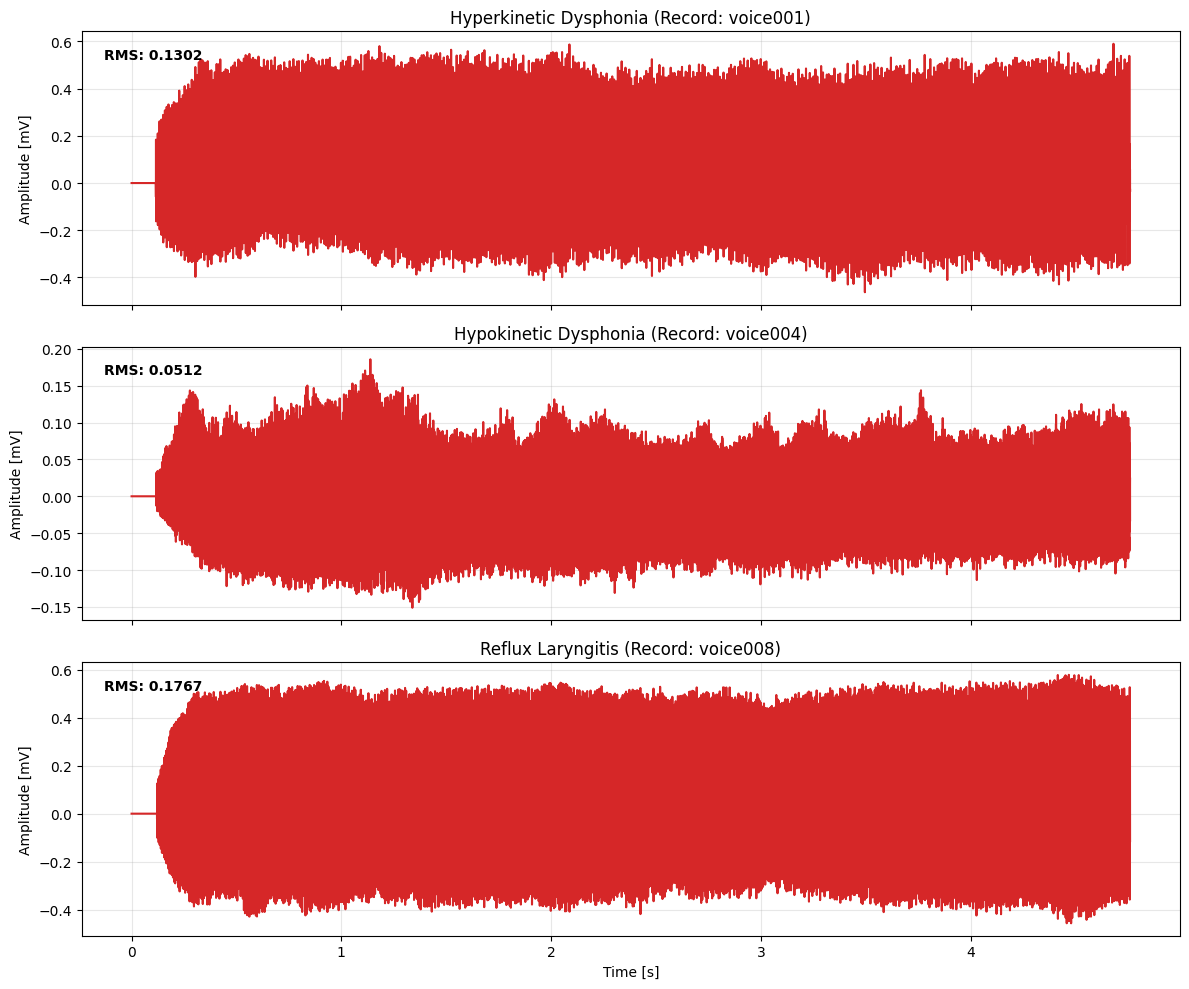

In [14]:
unique_pathologies = ['hyperkinetic dysphonia', 'hypokinetic dysphonia', 'reflux laryngitis']
found_examples = {}

for record_id, (sig, diag_raw) in voice_signal_diagnosis.items():
    diag = str(diag_raw).lower().strip()
    
    
    if 'hyperkineti' in diag: diag = 'hyperkinetic dysphonia'
    elif 'hypokinetic' in diag: diag = 'hypokinetic dysphonia'
    elif 'reflux' in diag: diag = 'reflux laryngitis'
    
    
    if diag in unique_pathologies and diag not in found_examples:
        found_examples[diag] = (record_id, sig)
    
    if len(found_examples) == len(unique_pathologies):
        break


print(f"Plotting examples for: {list(found_examples.keys())}")
fig, axs = plt.subplots(len(found_examples), 1, figsize=(12, 10), sharex=True)

for i, (pathology, (rec_id, sig)) in enumerate(found_examples.items()):
    
    t = np.arange(len(sig)) / sampling_rate
    
    axs[i].plot(t, sig, color='tab:red')
    axs[i].set_title(f"{pathology.title()} (Record: {rec_id})")
    axs[i].set_ylabel("Amplitude [mV]")
    axs[i].grid(True, alpha=0.3)
    
    
    rms = np.sqrt(np.mean(sig**2))
    axs[i].text(0.02, 0.9, f"RMS: {rms:.4f}", transform=axs[i].transAxes, fontweight='bold')

if len(found_examples) > 0:
    axs[-1].set_xlabel("Time [s]")
    plt.tight_layout()
    plt.show()
else:
    print("No pathological examples found matching the exact names.")

Tady analyzuji spektrální vlastnosti hlasu pomocí FFT a cepstra, rozděluji energii do frekvenčních pásem, kombinuji je s předchozími příznaky a pomocí KNN modelu ověřuji přesnost klasifikace.

Plotting Cepstrums for: ['hyperkinetic dysphonia', 'hypokinetic dysphonia', 'reflux laryngitis']


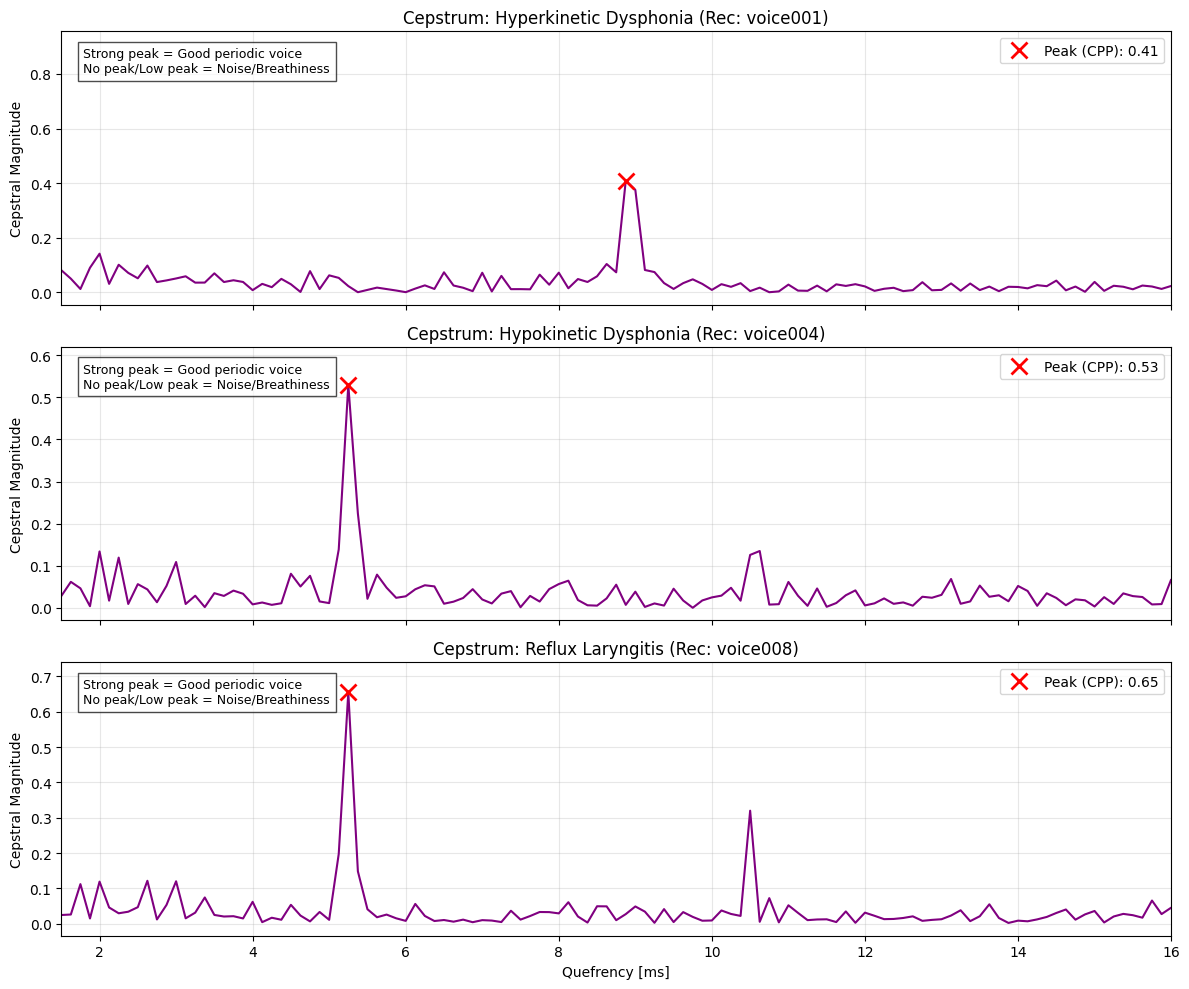

In [ ]:
print(f"Plotting Cepstrums for: {list(found_examples.keys())}")
fig, axs = plt.subplots(len(found_examples), 1, figsize=(12, 10), sharex=True)

for i, (pathology, (rec_id, sig)) in enumerate(found_examples.items()):
    
    center = len(sig) // 2
    frame_len = int(0.04 * fs) 
    start = center - frame_len // 2
    frame = sig[start : start + frame_len]
    
    if np.std(frame) == 0: continue
    frame = (frame - np.mean(frame)) / np.std(frame)
    
    
    windowed = frame * np.hanning(len(frame))
    spectrum = np.abs(fft.rfft(windowed))
    log_spec = np.log(spectrum + 1e-9)
    cepstrum = np.abs(fft.irfft(log_spec))
    
    quefrency_ms = np.arange(len(cepstrum)) / fs * 1000
    
    
    axs[i].plot(quefrency_ms, cepstrum, color='purple')
    
    axs[i].set_xlim(1.5, 16) 
    
    min_idx = int(1.5 * fs / 1000)
    max_idx = int(16 * fs / 1000)
    
    if max_idx < len(cepstrum):
        region = cepstrum[min_idx:max_idx]
        if len(region) > 0:
            peak_val = np.max(region)
            peak_idx = min_idx + np.argmax(region)
            
            
            axs[i].plot(quefrency_ms[peak_idx], peak_val, 'rx', markersize=12, markeredgewidth=2, label=f'Peak (CPP): {peak_val:.2f}')
            axs[i].legend(loc='upper right')

    axs[i].set_title(f"Cepstrum: {pathology.title()} (Rec: {rec_id})")
    axs[i].set_ylabel("Cepstral Magnitude")
    axs[i].grid(True, alpha=0.3)
    axs[i].text(0.02, 0.85, "Strong peak = Good periodic voice\nNo peak/Low peak = Noise/Breathiness", transform=axs[i].transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

axs[-1].set_xlabel("Quefrency [ms]")
plt.tight_layout()
plt.show()

In [ ]:
# Vyhodnoceni algoritmu na testovacich dat
def get_spectral_bands(signal, fs):
    try:
        windowed = signal * np.hanning(len(signal))
        spectrum = np.abs(fft.rfft(windowed)) ** 2  
        freqs = fft.rfftfreq(len(signal), 1/fs)
        
        total_energy = np.sum(spectrum)
        if total_energy == 0: return 0, 0, 0

        
        idx_low = (freqs <= 800)
        idx_mid = (freqs > 800) & (freqs <= 2500)
        idx_high = (freqs > 2500)

       
        e_low = np.sum(spectrum[idx_low])
        e_mid = np.sum(spectrum[idx_mid])
        e_high = np.sum(spectrum[idx_high])

        
        return e_low/total_energy, e_mid/total_energy, e_high/total_energy
        
    except Exception as e:
        return 0, 0, 0

print("Extracting Spectral Band Features...")

clean_feature_set = []

for record_id, (sig, diag_raw) in voice_signal_diagnosis.items():
    diag = str(diag_raw).lower().strip()
    
    
    if 'hyperkineti' in diag: label = 'hyperkinetic dysphonia'
    elif 'hypokinetic' in diag: label = 'hypokinetic dysphonia'
    elif 'reflux' in diag: label = 'reflux laryngitis'
    else: continue 

    
    low_band, mid_band, high_band = get_spectral_bands(sig, fs=sampling_rate)
    
    
    jit, shim = get_jitter_shimmer(sig, fs=sampling_rate)
    cpp = get_cpp(sig, fs=sampling_rate)

    clean_feature_set.append([low_band, mid_band, high_band, jit, shim, cpp, label])


df_spectral = pd.DataFrame(clean_feature_set, columns=['LowFreq', 'MidFreq', 'HighFreq', 'Jitter', 'Shimmer', 'CPP', 'Diagnosis'])



X_new = df_spectral[['LowFreq', 'MidFreq', 'HighFreq', 'Jitter', 'Shimmer', 'CPP']]
y_new = df_spectral['Diagnosis']


imputer = SimpleImputer(strategy='median')
X_new = imputer.fit_transform(X_new)


X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    X_new, y_new, test_size=0.2, random_state=42, stratify=y_new
)


knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')) 
])

knn.fit(X_train_n, y_train_n)
y_pred_n = knn.predict(X_test_n)

print(f"\n--- Spectral Band + k-NN Results (Test Split) ---")
print(f"Accuracy: {accuracy_score(y_test_n, y_pred_n) * 100:.2f}%")



print("\n--- Running 10-Fold Cross-Validation on FULL Dataset ---")
cv_scores_knn = cross_val_score(knn, X_new, y_new, cv=10, scoring='accuracy')

print(f"Mean Accuracy: {cv_scores_knn.mean() * 100:.2f}%")
print(f"Standard Deviation: +/- {cv_scores_knn.std() * 100:.2f}%")
print(f"Min Score: {cv_scores_knn.min() * 100:.2f}%")
print(f"Max Score: {cv_scores_knn.max() * 100:.2f}%")



Extracting Spectral Band Features...

--- Spectral Band + k-NN Results (Test Split) ---
Accuracy: 41.94%

--- Running 10-Fold Cross-Validation on FULL Dataset ---
Mean Accuracy: 48.96%
Standard Deviation: +/- 8.66%
Min Score: 26.67%
Max Score: 60.00%


V práci jsem provedl analýzu hlasových signálů a jejich klasifikaci na zdravé a patologické případy pomocí akustických a spektrálních příznaků. Kombinací parametrů Jitter, Shimmer a CPP spolu s klasifikátorem Random Forest jsem dosáhl přesnosti 93 % při binární klasifikaci.

Při rozlišování konkrétních typů patologických onemocnění byla úloha náročnější – po rozšíření příznaků o spektrální analýzu a použití klasifikátoru k-NN jsem dosáhl průměrné přesnosti 49 %, což je více než náhodná klasifikace (33 %), ale zároveň to ukazuje omezení jednodušších metod.

Z práce vyplývá, že automatická detekce patologie hlasu je možná s vysokou spolehlivostí, avšak přesné rozlišení jednotlivých onemocnění vyžaduje pokročilejší modely a komplexnější přístup ke zpracování signálu.